# LR Pro Fitting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import json
from io import StringIO
import itertools
import re

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import integrate

# import utility functions
from my_utils import *


### Set Run Params

For a single LR run.

In [3]:
template_path = "./data/pro_template.csv"
data_path = "./data/pro_stds/"
ref_pk_window = [-0.02, 0.02]
ref_pk_tolerance_window = [0,0]
multiplets_ls = [[1.9,2.15], 
                 [2.305, 2.408],
                 [3.25, 3.5],
                 [4.1, 4.2]]
search_region_padding_size = 0.02
dept_var = "auc_target"
conc_dict = {
      "01":5104,
      "02":2041.6,
      "03":1020.8,
      "04":816.64,
      "05":510.4,
      "06":306.24,
      "07":127.6,
      "08":51.04,
      "09":25.52,
      "10":10.208,
      "11":0
   }

fn_out_json = "./results/lr-results-sample.json"
fn_out_plot = "./results/lr-results-sample-plot.svg"
fn_out_df = "./results/lr-results-sample-df.csv"

### Run

In [4]:
# ========== load data ==========
# read all csvs from a given input folder into df_dict{}
df_dict = {}
for fn in os.listdir(data_path):
    if (".csv" in fn) and ("pro_std_" in fn):
        dt = pd.read_csv(os.path.join(data_path, fn))
        k = fn.replace(".csv", "")
        
        # flag ref_pks that aren't within ref_pk_tolerance_window?
        # adjust ref pk
        dt = adjust_to_ref_peak(dt, ref_pk_window, ref_pk_tolerance_window)
        df_dict[k] = dt

# iterate over sorted keys for neatness
keys_ls = sorted(list(df_dict.keys()))

# load template
query_df = pd.read_csv(template_path)


# ========== do 1d_std_search ==========
# store results in a results_dict
results_dict = {}
for k, target_df in df_dict.items():
    results_dict[k] = do_1d_std_search(query_df, 
                                       target_df, 
                                       multiplets_ls,
                                       query_l_dict={}, 
                                       search_region_padding_size=search_region_padding_size,
                                       floor_window=True
                                      )

    
# ========== get df_auc ==========
df_conc = get_df_auc(query_df, df_dict, results_dict, multiplets_ls)
# augment df_auc with conc data
c = []
for k, conc in conc_dict.items():
    c.append([f"pro_std_{k}_r1", conc])
    c.append([f"pro_std_{k}_r2", conc])

dt = pd.DataFrame(data=c, columns=["sample_name", "conc"])
df_conc = pd.merge(df_conc, dt, on="sample_name")


# ========== do LR/polyfitting ==========
mkeys_ls = [f"multiplet_{i}" for i in np.arange(len(multiplets_ls))]
lr_results_dict = {}
for mkey in mkeys_ls:
    dt = df_conc.loc[df_conc["multiplet"]==mkey]
    # with statsmodels, to return CIs
    Y = dt.conc.values
    X = dt[dept_var].values
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)

    results = model.fit()
    row_dict = {
        "intercept":results.params[0],
        "intercept_ci":list(results.conf_int()[0]),
        "gradient":results.params[1],
        "gradient_ci":list(results.conf_int()[1]),
        "rsquared":results.rsquared,
        "rsquared_adj":results.rsquared_adj
    }
    lr_results_dict[mkey] = row_dict


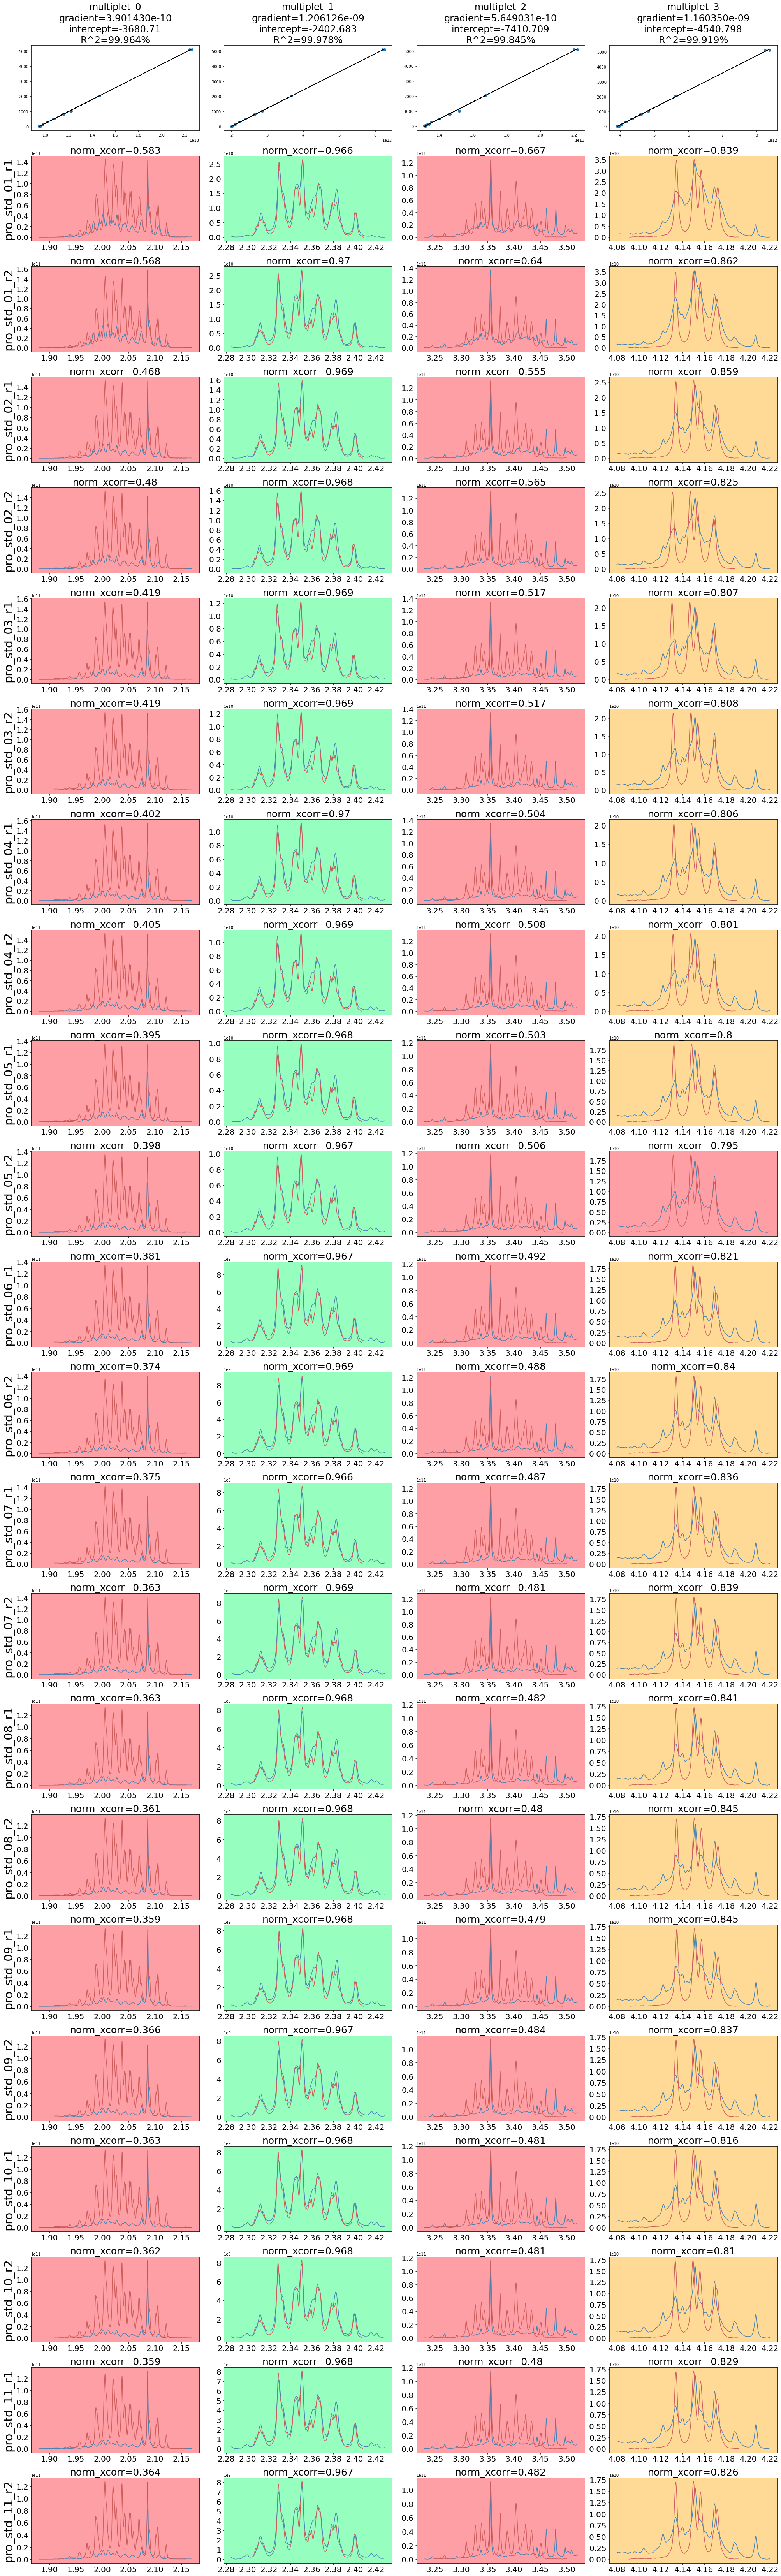

In [5]:
# plot std_search/scaling factor results
fig, ax = plt.subplots(nrows=len(keys_ls)+1, # top row for LR results
                       ncols=len(multiplets_ls), 
                       figsize=(28, (len(keys_ls)+1)*4)
                      )

# viz LR
for j in range(len(list(lr_results_dict.keys()))):
    k = f"multiplet_{j}"
    dt = df_conc.loc[df_conc["multiplet"]==k].copy()
    ax[0, j].scatter(x=dt[dept_var].values, y=dt.conc.values)
    
    x = dt[dept_var].values
    y_fit = lr_results_dict[k]["gradient"]*x + lr_results_dict[k]["intercept"]
    ax[0, j].plot(dt[dept_var].values, y_fit, c="k")
    
    # title
    lr_stats_str = "\n".join([k,
                              f"gradient={'{:e}'.format(lr_results_dict[k]['gradient'])}", 
                              f"intercept={round(lr_results_dict[k]['intercept'], 3)}", 
                              f"R^2={round(lr_results_dict[k]['rsquared_adj']*100, 3)}%"])
    ax[0, j].set_title(lr_stats_str, fontsize=24)


# viz fit
for i in range(len(keys_ls)):
    k = keys_ls[i]
    
    for j in range(len(multiplets_ls)):
        mcoords = multiplets_ls[j]
        # plot sample (blue)
        dt_target = df_dict[k]
        dt_target = dt_target.loc[(dt_target["ppm"]>min(mcoords)-search_region_padding_size) & 
                                  (dt_target["ppm"]<max(mcoords)+search_region_padding_size)].copy()
        target_intensity_arr = dt_target["intensity"].values - min(dt_target["intensity"].values)
        dt_target["intensity"] = target_intensity_arr

        ax[i+1, j].plot(dt_target.ppm.values, dt_target.intensity.values, c="steelblue")
        
        # plot fit (red)
        # shift ppm
        ppm_shift = max(mcoords) - max(results_dict[k][f"multiplet_{j}"]["multiplet_match_ppm"][0])
        multiplet_df = query_df.loc[(query_df["ppm"]>min(mcoords)) & (query_df["ppm"]<max(mcoords))].copy()
        new_ppm_arr = multiplet_df.ppm.values - ppm_shift
        multiplet_df["ppm"] = new_ppm_arr
        
        # floor spectra
        query_intensity_arr = multiplet_df["intensity"].values - min(multiplet_df["intensity"].values)
        multiplet_df["intensity"] = query_intensity_arr
        
        # get sf
        conc = float(conc_dict[k.split("_")[2]])
        sf = df_conc.loc[(df_conc["multiplet"]==f"multiplet_{j}") & (df_conc["conc"]==conc)].scaling_factor.values[0]
    
        ax[i+1, j].plot(multiplet_df.ppm.values, multiplet_df.intensity.values/sf, c="indianred")
        #if j == 0:
        #    ax[i+1, j].set_title(f"norm_xcorr={k}", fontsize=25)

        # set bg colour
        xcorr = max(results_dict[k][f"multiplet_{j}"]["rho_ls"])
        bg_colour = "#FE9FA5"
        if xcorr > 0.8 and xcorr < 0.9:
            bg_colour = "#FEDA96"
        elif xcorr >= 0.9:
            bg_colour = "#96FEBF"
        ax[i+1, j].set_facecolor(bg_colour)
        ax[i+1, j].set_title(f"norm_xcorr={round(xcorr, 3)}", fontsize=25)
        plt.setp(ax[i+1, j].get_xticklabels(), fontsize=20)
        plt.setp(ax[i+1, j].get_yticklabels(), fontsize=20)
        
        # yaxis labels with conc values
        if j == 0:
            ax[i+1, j].set_ylabel(k, fontsize=30)

plt.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.show()

i = StringIO()
fig.savefig(i, format="svg")
output_svg = i.getvalue().strip().split("\n")

plt.close()

# resize svg
resize_coeff = 0.4
for i in range(len(output_svg)):
    if "<svg height" in output_svg[i]:
        pattern = re.compile(r'<svg height="\d{1,10}pt"')
        my_match = re.findall(pattern, output_svg[i])[0]
        current_val = int(my_match.replace('<svg height="', '').replace('pt"',''))
        new_str = f'<svg height="{int(current_val*resize_coeff)}pt"'
        output_svg[i] = output_svg[i].replace(my_match, new_str)

        pattern = re.compile(r'width="\d{1,10}pt"')
        my_match = re.findall(pattern, output_svg[i])[0]
        current_val = int(my_match.replace('width="', '').replace('pt"',''))
        new_str = f'width="{int(current_val*resize_coeff)}pt"'
        output_svg[i] = output_svg[i].replace(my_match, new_str)

# prep html contents
html_contents = ["<html><head></head><body>"]
for line in output_svg:
    html_contents.append(line)
html_contents.append("</body></html>")


In [8]:
# write out everything
with open(fn_out_plot, "w") as f:
    for line in html_contents:
        f.write(line)

df_conc.to_csv(fn_out_df, index=False)

with open(fn_out_json, "w") as f:
    json.dump(lr_results_dict, f)
